# seq2seq+attn 스페인-영어 번역기

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

## 데이터 불러오기

In [ ]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)

In [ ]:
path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

print(path_to_file)

/root/.keras/datasets/spa-eng/spa.txt


In [ ]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size : ", len(raw))
print("Example : ")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size :  118964
Example : 
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


\t 

## 데이터 전처리 : 정제하기

In [ ]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence
    
    if e_token:
        sentence += ' <end>'

    return sentence

In [ ]:
enc_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng)) # 영어를 preprocess_sentence 함수를 통과해서 담아주세요.
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True)) # 스페인어를 preprocess_sentence 함수를 통과해서 담아주세요.

print("English :", enc_corpus[100]) # 영어 텍스트
print("Spanish :", dec_corpus[100]) # 스페인 텍스트

English : go away !
Spanish : <start> salga de aqu ! <end>


## 데이터 전처리 : 토큰화

In [ ]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [ ]:
# 토큰화 : tokenize함수를 사용하여, encoder, decoder 각각을 통과해주세요.
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기 (80/20) ---> test_size = 0.2
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size : ", len(enc_tokenizer.index_word))
print("Spanish Vocab Size : ", len(dec_tokenizer.index_word))

English Vocab Size :  4931
Spanish Vocab Size :  8893


# 모델 설계

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_decoder = tf.keras.layers.Dense(units)
        self.w_encoder = tf.keras.layers.Dense(units)
        self.w_combine = tf.keras.layers.Dense(1)
    
    def call(self, h_encoder, h_decoder):
        # h_enc shape : [batch x length x units]
        # h_dec shape : [batch x units]

        h_encoder = self.w_encoder(h_encoder)

        h_decoder = tf.expand_dims(h_decoder, 1)
        h_decoder = self.w_decoder(h_decoder)

        score = self.w_combine(tf.nn.tanh(h_decoder + h_encoder))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * h_decoder
        context_vector = tf.reduce_sum(context_vector, axis = 1)

        return context_vector, attention_weights

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        #print("컨텍스트 벡터의 차원 : ", context_vec.shape) #(64, 1024)
    
        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis= -1)

        out, h_dec = self.gru(out)
        #print("gru 차원 : ", out.shape) #(64, 1, 1024)
        
        out = tf.reshape(out, (-1, out.shape[2])) # (64, 1024)
        #print("변경된 out의 차원 : ", out.shape)
        out = self.fc(out) 
        #print("fc 거친 out의 차원 :", out.shape) # (64, 8894)

        return out, h_dec, attn

In [ ]:
# encoder와 decoder 단어장 크기 확인하기
batch_size = 64
src_vocab_size = len(enc_tokenizer.index_word) + 1
tgt_vocab_size = len(dec_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(src_vocab_size, embedding_dim, units)
decoder = Decoder(tgt_vocab_size, embedding_dim, units)

'''
sample input 
tf. random.uniform으로 만들어서 모델에 들어가는 shape 확인하기 (encoder)
'''
sequence_len = 30

sample_enc = tf.random.uniform((batch_size, sequence_len))
sample_output = encoder(sample_enc)

print('Encoder Output: ', sample_output.shape)

'''
sample input 
tf. random.uniform으로 만들어서 모델에 들어가는 shape 확인하기 (decoder)
'''

sample_state = tf.random.uniform((batch_size, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((batch_size, 1)), sample_state, sample_output)

print('Decoder output :', sample_logits.shape)
print('Decoder Hidden state :', h_dec.shape)
print('Attention :', attn.shape)

Encoder Output:  (64, 30, 1024)
Decoder output : (64, 8894)
Decoder Hidden state : (64, 1024)
Attention : (64, 30, 1)


## 훈련하기 : Optimizer & loss

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # 모델 출력값을 그대로 전달한다.

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype) # <PAD>
    loss *= mask

    return tf.reduce_mean(loss)

    #[ 0.1 0.2 0.7] ----> 2

## 훈련하기 : train_step 구하기

train step 학습과정
1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out을 생성
2. Decoder에 입력으로 전달할 토큰 문장 생성
3. t=0일 때, Decoder의 Hidden state는 Encoder의 Final state로 정의. h_dec = enc_out[:, -1]
4. 문장과 enc_out, Hidden state를 기반으로 다음단어 (t=1)예측 pred
5. 예측된 단어와 정답간의 loss을 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측단어X)
6. 반복!

In [ ]:
@tf.function # 가속 연산
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape: # 학습하면서 발생한 모든 연산을 기록하는 테이프  # tf.GradientTape() 미분하는 메서드
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

## 훈련하기 : 훈련시작하기

In [ ]:
from tqdm import tqdm  # tqdm 프로그래스 bar 만들기 -> verbose 대체
import random

epochs = 10

for epoch in range(epochs):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], batch_size))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+batch_size],
                                dec_train[idx:idx+batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch 10: 100%|██████████| 375/375 [00:45<00:00,  8.27it/s, Loss 0.6192]


In [ ]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
  bsz = src.shape[0]
  loss =0

  enc_out = encoder(src)
  h_dec = enc_out[:, -1]

  dec_src = tf.expand_dims([dec_tok.word_index['<start>']]* bsz, 1)

  for t in range(1, tgt.shape[1]):
    pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
    loss += loss_function(tgt[:, t], pred)
    dec_src = tf.expand_dims(tgt[:, t], 1)

  batch_loss = (loss/int(tgt.shape[1]))

  return batch_loss

In [ ]:
# Training Process
from tqdm import tqdm

EPOCHS = 1

for epoch in range(EPOCHS):
  total_loss = 0

  idx_list = list(range(0, enc_train.shape[0], batch_size))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (batch, idx) in enumerate(t):
    batch_loss = train_step(enc_train[idx:idx+batch_size],
                            dec_train[idx:idx+batch_size],
                            encoder,
                            decoder,
                            optimizer,
                            dec_tokenizer)
    total_loss += batch_loss

  t.set_description_str('Epoch %2d' % (epoch +1))
  t.set_postfix_str('Loss %.4f' % (total_loss.numpy()/ (batch+1)))

  test_loss = 0

  idx_list = list(range(0, enc_val.shape[0], batch_size))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (test_batch, idx) in enumerate(t):
    test_batch_loss = eval_step(enc_val[idx:idx+batch_size],
                                dec_val[idx:idx+batch_size],
                                encoder,
                                decoder,
                                dec_tokenizer)
    test_loss += test_batch_loss

  t.set_description_str('Test Epoch %2d' % (epoch+1))
  t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy()/ (test_batch+1)))

100%|██████████| 94/94 [00:15<00:00,  6.17it/s]


In [ ]:
def evaluate(sentence, encoder, decoder):
  attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
  sentence = preprocess_sentence(sentence)
  inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                         maxlen = enc_train.shape[-1],
                                                         padding= 'post')
  
  result = ''
  enc_out = encoder(inputs)
  dec_hidden = enc_out[:, -1]
  dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

  for t in range(dec_train.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention[t] = attention_weights.numpy()

    predicted_id = \
    tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

    result += dec_tokenizer.index_word[predicted_id] + ' '

    if dec_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence, encoder, decoder):
  result, sentence, attention = evaluate(sentence, encoder, decoder)

  print('Input : %s' % (sentence))
  print('Predicted translation : {}'.format(result))

  attention = attention[:len(result.split()), :len(sentence.split())]
  plot_attention(attention, sentence.split(), result.split(' '))

Input : can i have some coffee ?
Predicted translation : puedo ir a la puerta ? <end> 


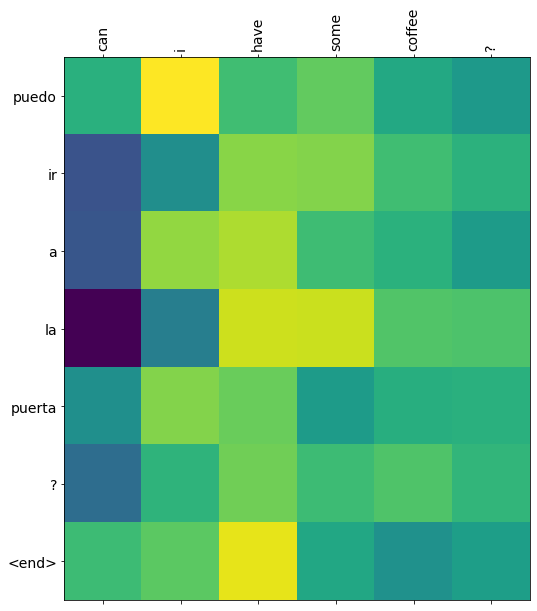

In [ ]:
translate("Can I have some coffee?", encoder, decoder)

# Proj. 한-영 번역기 만들기

한-영 번역기 만들기
1. 데이터 다운로드
- 데이터 : https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1
- korean-english-park.train.tar.gz
2. 데이터 정제
- set 데이터형이 중복이 허용하지 않다는 것을 활용해 중복된 데이터를 제거
  - 데이터 병렬 쌍이 흐트러지지 않게 주의!
  - cleaned_corpus에 저장
- 앞서 정의한 preprocessing()함수는 한글에 대해 동작하지 않아요.
  - 한글에 적용할 수 있는 정규식을 추가해여 함수를 재정의 하세요.
- 타겟 언어인 영문엔 <\start>토큰과 <\end>토큰을 추가하고 split()함수로 토큰화 합니다. 한글 토큰화는 konlpy의 mecab클래스를 사용합니다.
  - cleaned_corpus로부터 토큰의길이가 40이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하기

3. 토큰화
- tokenize()함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요!
  - 단어수는 실험을 통해 적당한 값을 맞춰줍시다(최소 10000이상!)
4. 훈련하기

In [9]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker

import time
import re
import os
import io

In [2]:
# 한글 폰트 준비 및 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [3]:
# import urllib.request
# urllib.request.urlretrieve("https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1", filename="korean-english-park.train.tar.gz") # train
# path = tf.keras.utils .get_file('korean-english-park.train.tar.gz', origin='https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1/korean-english-park.train.tar.gz', extract=True)
!wget "https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz"

--2022-05-30 00:25:50--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-05-30 00:25:50--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean-eng

In [4]:
# 압축 풀기
!tar -xzvf korean-english-park.train.tar.gz

korean-english-park.train.en
korean-english-park.train.ko


In [10]:
# 파일 읽기
path_to_file = os.path.dirname('/content/korean-english-park.train.ko') + '/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw_ko = f.read().splitlines()

print("Data Size : ", len(raw_ko))
print("Example : ")

for sen in raw_ko[0:100][::20]: print(">>", sen)

Data Size :  94123
Example : 
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [11]:
# 파일 읽기
path_to_file = os.path.dirname('/content/korean-english-park.train.en') + '/korean-english-park.train.en'

with open(path_to_file, "r") as f:
    raw_en = f.read().splitlines()

print("Data Size : ", len(raw_en))
print("Example : ")

for sen in raw_en[0:100][::20]: print(">>", sen)

Data Size :  94123
Example : 
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


In [12]:
def preprocess_sentence_ko(sentence, s_token=False, e_token=False):


    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence
    
    if e_token:
        sentence += ' <end>'

    return sentence

In [13]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence
    
    if e_token:
        sentence += ' <end>'

    return sentence

In [14]:
enc_corpus = []
dec_corpus = []

# num_examples = 10000
num_examples = 1000

for kor in raw_ko[:num_examples]:
    enc_corpus.append(preprocess_sentence_ko(kor)) # 한국어를 preprocess_sentence 함수를 통과해서 담아주세요.

for eng in raw_en[:num_examples]:
    dec_corpus.append(preprocess_sentence(eng, s_token=True, e_token=True)) # 영어를 preprocess_sentence 함수를 통과해서 담아주세요.

print("Korean :", enc_corpus[100]) # 한국어 텍스트
print("English :", dec_corpus[100]) # 영어 텍스트

Korean : 제  차 연례 컴덱스 박람회의 개회사를 한 케이츠는  년여전 기술 산업의 거품이 붕괴된 이후에 첨단 기술에 대해 부정적인 인식이 있다고 말했다
English : <start> gates , who opened the rd annual comdex trade show , said there was a negative perception of high tech following the collapse of the tech bubble about two years ago . <end>


In [8]:
# mecab 설치
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-05-30 01:15:16--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00::22c5:2ef4, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=hH8FdFKtZ7xlH7M%2B9m%

In [43]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw_ko))
print("Data Size : ", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

avg_len = sum_len//len(cleaned_corpus)
print('문장의 최단 길이 :', min_len)
print('문장의 최장 길이 :', max_len)
print('문장의 평균 길이 :', avg_len)

Data Size :  77591
문장의 최단 길이 : 1
문장의 최장 길이 : 377
문장의 평균 길이 : 64


In [44]:
from konlpy.tag import Mecab

def return_macab_corpus(corpus, tokenizer):

    # output_tokens = [ '[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]' ]
    output_tokens = []

    for sentence in corpus:
        token = tokenizer.morphs(sentence)

        # if token in output_tokens:
        #     continue
        
        output_tokens.append(token)

    return output_tokens

In [45]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',oov_token="<OOV>")
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=avg_len)

    return tensor, tokenizer

In [46]:
# 토큰화 : tokenize함수를 사용하여, encoder, decoder 각각을 통과해주세요.
mecab = Mecab()

enc_corpus_ko = return_macab_corpus(enc_corpus, mecab)
enc_tensor, enc_tokenizer = tokenize(enc_corpus_ko)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)



In [47]:
print(enc_corpus)
print(enc_tokenizer.index_word)

print(dec_tokenizer.index_word )

['개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐', '모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다', '그러나 이것은 또한 책상도 필요로 하지 않는다', '달러하는 이 최첨단 무선 광마우스는 허공에서 팔목   팔   그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다', '정보 관리들은 동남 아시아에서의 선박들에 대한 많은  테러  계획들이 실패로 돌아갔음을 밝혔으며   세계 해상 교역량의 거의  분의  을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다', '이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의  테러  시도 중 여러 건이 실패했다는 것을 알게 된 후에   전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며   동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다', '국립 과학 학회가 발표한 새 보고서에따르면   복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다', '이 보고서에따르면   특히   군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다   고 한다', '결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다', '연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고  는 말했다', '약  밀리그램의   비슷한 분량의 카페인은 또한 육체적 지구력을 강화시키는 데 효과적인 것 같으며   특히 고도가 높은 곳에서 약해진 육체적 지구력을 일부 회복시켜주는 데 유용하다는 것이 이번 연구에서 밝혀졌다', '의약 연구소는 정부에 과학 문제에 관해 자문하기 위

In [48]:
print("Korean Vocab Size : ", len(enc_tokenizer.index_word))
print("English Vocab Size : ", len(dec_tokenizer.index_word))
print("Korean shape : ", enc_tensor.shape)
print("English shape : ", dec_tensor.shape)

Korean Vocab Size :  4215
English Vocab Size :  4346
Korean shape :  (1000, 64)
English shape :  (1000, 64)


In [49]:
# 훈련 데이터와 검증 데이터로 분리하기 (80/20) ---> test_size = 0.2
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size=0.2)

In [50]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_decoder = tf.keras.layers.Dense(units)
        self.w_encoder = tf.keras.layers.Dense(units)
        self.w_combine = tf.keras.layers.Dense(1)
    
    def call(self, h_encoder, h_decoder):
        # h_enc shape : [batch x length x units]
        # h_dec shape : [batch x units]

        h_encoder = self.w_encoder(h_encoder)

        h_decoder = tf.expand_dims(h_decoder, 1)
        h_decoder = self.w_decoder(h_decoder)

        score = self.w_combine(tf.nn.tanh(h_decoder + h_encoder))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * h_decoder
        context_vector = tf.reduce_sum(context_vector, axis = 1)

        return context_vector, attention_weights

In [51]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [52]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        #print("컨텍스트 벡터의 차원 : ", context_vec.shape) #(64, 1024)
    
        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis= -1)

        out, h_dec = self.gru(out)
        #print("gru 차원 : ", out.shape) #(64, 1, 1024)
        
        out = tf.reshape(out, (-1, out.shape[2])) # (64, 1024)
        #print("변경된 out의 차원 : ", out.shape)
        out = self.fc(out) 
        #print("fc 거친 out의 차원 :", out.shape) # (64, 8894)

        return out, h_dec, attn

In [53]:
# encoder와 decoder 단어장 크기 확인하기
batch_size = 64
src_vocab_size = len(enc_tokenizer.index_word) + 1
tgt_vocab_size = len(dec_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(src_vocab_size, embedding_dim, units)
decoder = Decoder(tgt_vocab_size, embedding_dim, units)

'''
sample input 
tf. random.uniform으로 만들어서 모델에 들어가는 shape 확인하기 (encoder)
'''
sequence_len = 30

sample_enc = tf.random.uniform((batch_size, sequence_len))
sample_output = encoder(sample_enc)

print('Encoder Output: ', sample_output.shape)

'''
sample input 
tf. random.uniform으로 만들어서 모델에 들어가는 shape 확인하기 (decoder)
'''

sample_state = tf.random.uniform((batch_size, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((batch_size, 1)), sample_state, sample_output)

print('Decoder output :', sample_logits.shape)
print('Decoder Hidden state :', h_dec.shape)
print('Attention :', attn.shape)

Encoder Output:  (64, 30, 1024)
Decoder output : (64, 4347)
Decoder Hidden state : (64, 1024)
Attention : (64, 30, 1)


In [54]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') # 모델 출력값을 그대로 전달한다.

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real,0))
    loss = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss.dtype) # <PAD>
    loss *= mask

    return tf.reduce_mean(loss)

    #[ 0.1 0.2 0.7] ----> 2

In [55]:
@tf.function # 가속 연산
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape: # 학습하면서 발생한 모든 연산을 기록하는 테이프  # tf.GradientTape() 미분하는 메서드
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [56]:
from tqdm import tqdm  # tqdm 프로그래스 bar 만들기 -> verbose 대체
import random

# epochs = 10
# 빠른 결과를 확인하기 위해서 디버깅 모드로 1번만 학습
epochs = 1

for epoch in range(epochs):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], batch_size))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+batch_size],
                                dec_train[idx:idx+batch_size],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch  1: 100%|██████████| 13/13 [12:31<00:00, 57.77s/it, Loss 2.3379]


In [59]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
  bsz = src.shape[0]
  loss =0

  enc_out = encoder(src)
  h_dec = enc_out[:, -1]

  dec_src = tf.expand_dims([dec_tok.word_index['<start>']]* bsz, 1)

  for t in range(1, tgt.shape[1]):
    pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
    loss += loss_function(tgt[:, t], pred)
    dec_src = tf.expand_dims(tgt[:, t], 1)

  batch_loss = (loss/int(tgt.shape[1]))

  return batch_loss

In [60]:
# Training Process
from tqdm import tqdm

EPOCHS = 1

for epoch in range(EPOCHS):
  total_loss = 0

  idx_list = list(range(0, enc_train.shape[0], batch_size))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (batch, idx) in enumerate(t):
    batch_loss = train_step(enc_train[idx:idx+batch_size],
                            dec_train[idx:idx+batch_size],
                            encoder,
                            decoder,
                            optimizer,
                            dec_tokenizer)
    total_loss += batch_loss

  t.set_description_str('Epoch %2d' % (epoch +1))
  t.set_postfix_str('Loss %.4f' % (total_loss.numpy()/ (batch+1)))

  test_loss = 0

  idx_list = list(range(0, enc_val.shape[0], batch_size))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (test_batch, idx) in enumerate(t):
    test_batch_loss = eval_step(enc_val[idx:idx+batch_size],
                                dec_val[idx:idx+batch_size],
                                encoder,
                                decoder,
                                dec_tokenizer)
    test_loss += test_batch_loss

  t.set_description_str('Test Epoch %2d' % (epoch+1))
  t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy()/ (test_batch+1)))

100%|██████████| 4/4 [01:47<00:00, 26.85s/it]


In [61]:
def evaluate(sentence, encoder, decoder):
  attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
  sentence = preprocess_sentence_ko(sentence)
  inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                         maxlen = enc_train.shape[-1],
                                                         padding= 'post')
  
  result = ''
  enc_out = encoder(inputs)
  dec_hidden = enc_out[:, -1]
  dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

  for t in range(dec_train.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention[t] = attention_weights.numpy()

    predicted_id = \
    tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

    result += dec_tokenizer.index_word[predicted_id] + ' '

    if dec_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention

In [62]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(20, 20))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [63]:
def translate(sentence, encoder, decoder):
  result, sentence, attention = evaluate(sentence, encoder, decoder)

  print('Input : %s' % (sentence))
  print('Predicted translation : {}'.format(result))

  attention = attention[:len(result.split()), :len(sentence.split())]
#   plot_attention(attention, sentence.split(), result.split(' '))

In [68]:
translate('그는 화학 성적이 매우 좋다.', encoder, decoder)
         

Input : 그는 화학 성적이 매우 좋다
Predicted translation : the , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , 


In [65]:
translate("나는 오늘 밥을 먹었다. 철수는 잠을 잤다.", encoder, decoder)

Input : 나는 오늘 밥을 먹었다   철수는 잠을 잤다
Predicted translation : the , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , 


In [41]:
translate("the cup of tea", encoder, decoder)

Input : 
Predicted translation : the . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
